# Model training with a tf.data pipeline - Reading from COS

This notebook shows how to build two models, one simple CNN and one larger based on VGG16, using image data stored on IBM Cloud Object Storage and available as a Data Connection in a WS Project. It is intended to be run in a Python 3.8 + GPU environment on CPDaaS although it could run from anywhere.

In this notebook, **data is read directly from COS** in a `tf.data` pipeline which means that we don't need to transfer all the data at once before starting to train a model.

In [1]:
import os
import ibm_boto3
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display

# do NOT import tensorflow until the environment variables needed to set up TF <-> COS connection are set
# import tensorflow as tf
# from tensorflow.keras import layers, optimizers as keras_optimizers

**[Insert your project token](https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/project-lib-python.html?context=cpdaas&audience=wdp) in the next cell by clicking on the three dots in the top right > Insert project token, or grab it from the project's settings**

In [2]:
# @hidden_cell
from project_lib import Project
project = Project(project_id='b53259b3-66ae-4332-824e-0589a417c6dd', project_access_token='<replace-me>')

### Hyperparameters

In [3]:
IMG_SIZE = (150, 150)
CHANNELS = 3
BATCH_SIZE = 32
LOCAL_DIR = './'  # where to store data locally

LEARNING_RATE = 0.001
EPOCHS = 10
OPTIMIZER = 'Adam'
LOSS = 'sparse_categorical_crossentropy'
BATCH_SIZE = 32

# 0. Setup data connection

## 0.1 Get credentials

In [4]:
credentials = project.get_connection(name='intel-image-classification')
bucket_name = credentials['bucket']

print('Data is in bucket ', bucket_name)

Data is in bucket  intel-image-classification-kaggle


## 0.2 Connect to Cloud Object Storage

Cloud Object Storage implements the S3 APIs, which means you can interact with COS the same way you would interact with an AWS S3 bucket. In fact, here we are using the pre-installed `ibm_boto3` package but it could be replaced by `boto3` (also pre-installed) since the two packages behave similarly.

In [5]:
# s3 = ibm_boto3.resource('s3',
#                         aws_access_key_id=credentials['access_key'],
#                         aws_secret_access_key=credentials['secret_key'],
#                         endpoint_url=credentials['url'])
# bucket = s3.Bucket(bucket_name)

# # check that the connection is set up correctly:
# list(bucket.objects.limit(5).all())

## 0.3 Connect Tensorflow to Cloud Object Storage

Here we leverage the fact that Tensorflow can read data directly from COS in a similar fashion as AWS S3. The instructions to set up Tensorflow to do that are similar to a regular S3 tutorial to do so (e.g. [this example](https://github.com/tensorflow/examples/blob/master/community/en/docs/deploy/s3.md)) except for a couple points:
- we add the `S3_ENDPOINT` so that TF does not try to connect to AWS S3 but rather to IBM COS
    - make sure to remove the `https://` prefix in the url
    - and **make sure to use a private COS endpoint** if this notebook is running from within IBM Cloud. This will make data read more efficient and also eliminate any data transfer costs (since the data never leaves the IBM Cloud network).
- we set `S3_VERIFY_SSL` to False (0)

Once these variables are set up, Tensorflow will be able to interpret paths suchs as `s3://<mybucket>/<myfilename>`

In [6]:
os.environ['AWS_ACCESS_KEY_ID'] = credentials['access_key']
os.environ['AWS_SECRET_ACCESS_KEY'] = credentials['secret_key']

# for TF, remove https:// prefix:
os.environ['S3_ENDPOINT'] = 's3.private.us-south.cloud-object-storage.appdomain.cloud'

# avoid certificate issues when connecting to COS from TF:
os.environ['S3_VERIFY_SSL'] = "0"

## 0.4 Test the Tensorflow <> COS connection

We can now import tensorflow, which will read the environment variables above. We then perform a **smoke test** to make sure that data access is functioning correctly: we get the file statistic of one of the files we know exists in the bucket:

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, optimizers as keras_optimizers
from tensorflow.python.lib.io import file_io

In [8]:
path = f's3://{bucket_name}/intel-image-classification/seg_pred/seg_pred/10004.jpg'
file_io.stat(path)

The fact that this function call returned statistics (takes < 1 sec) means the data connection is set up correctly, TF can access our COS bucket!

# 1. Read and prepare dataset

## 1.1 Create list of remote files

In [9]:
train_keys_ds = tf.data.Dataset.list_files(f's3://{bucket_name}/intel-image-classification/seg_train/*/*/*.jpg')
val_keys_ds = tf.data.Dataset.list_files(f's3://{bucket_name}/intel-image-classification/seg_test/*/*/*.jpg')

## 1.2 Create a tf.data pipeline:

In [10]:
for f in train_keys_ds.take(5):
    print(f.numpy())

b's3://intel-image-classification-kaggle/intel-image-classification/seg_train/seg_train/mountain/15155.jpg'
b's3://intel-image-classification-kaggle/intel-image-classification/seg_train/seg_train/forest/8554.jpg'
b's3://intel-image-classification-kaggle/intel-image-classification/seg_train/seg_train/glacier/15389.jpg'
b's3://intel-image-classification-kaggle/intel-image-classification/seg_train/seg_train/sea/1858.jpg'
b's3://intel-image-classification-kaggle/intel-image-classification/seg_train/seg_train/street/11027.jpg'


In [11]:
class_names = np.array(sorted(set(key.decode().split('/')[-2] for key in train_keys_ds.as_numpy_iterator())))
class_names

array(['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'],
      dtype='<U9')

In [12]:
def get_label(file_path, class_names):
    """
    Given a file path, extract the label class and one hot encode it.
    Code from https://towardsdatascience.com/input-pipeline-for-images-using-keras-and-tensorflow-c5e107b6d7b9
    """
    # convert the path to a list of path components separated by sep
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    return tf.argmax(tf.cast(one_hot, tf.int32))

def process_path(file_path, image_size, channels, class_names):
    """
    Given a file path, extract the label, and read and process the image.
    """
    label = get_label(file_path, class_names)
    img_raw = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img_raw, channels=channels)
    img = tf.image.convert_image_dtype(img, tf.float32) # 0-255 to 0-1 range
    img = tf.image.resize(img, image_size)
    return img, label

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# train_keys_ds = train_keys_ds.take(1000) # for debug purposes
train_ds = train_keys_ds.map(lambda path: process_path(path, IMG_SIZE, CHANNELS, class_names),
                             num_parallel_calls=AUTOTUNE)

train_ds = train_ds.cache() # .cache('./train.tfcache')
train_ds = train_ds.shuffle(BATCH_SIZE, reshuffle_each_iteration=True)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
train_ds = train_ds.repeat(EPOCHS) # num epochs

train_ds.element_spec

(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [14]:
val_ds = val_keys_ds.map(lambda path: process_path(path, IMG_SIZE, CHANNELS, class_names),
                         num_parallel_calls=AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache() # './test.tfcache')

val_ds.element_spec

(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

## 1.5 Verify the data pipeline:

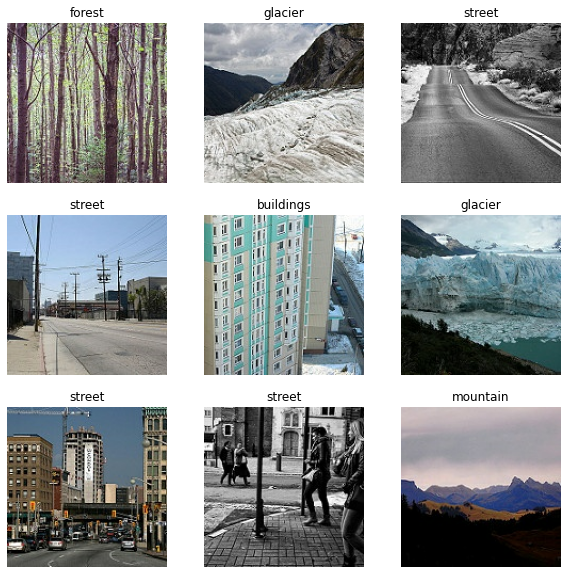

In [15]:
plt.figure(figsize=(10, 10))

iterator = iter(train_ds)
img_batch, label_batch = iterator.next()

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img_batch[i])
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

# 2. Build and train a model based on VGG16

See https://www.tensorflow.org/versions/r2.4/api_docs/python/tf/keras/applications/VGG16 and https://keras.io/api/applications/vgg/#vgg16-function

In this section, we build a model based on the VGG16 architecture, by leveraging the keras applications submodule. We load pre-trained weights trained on `imagenet` and add a couple additional layers on top to fit our problem (our dataset has 6 classes instead of 1000 in imagenet).

We use a couple callbacks to control what happens after each epoch:
- `ModelCheckpoint` will save the model after each epoch (replacing only if better)
- `ReduceLROnPlateau` will adjust the learning rate once there is low improvement in loss
- `EarlyStopping` will stop training if the loss does not improve for a given number of consecutive epochs

In [17]:
tf.keras.backend.clear_session()

In [18]:
def build_vgg_16(n_classes, input_shape, loss, optimizer, learning_rate, freeze=True):
    """
    Builds and compiles a model based on pre-trained VGG16 layers.   
    """
    # First, extract a pre-trained VGG16 base model
    base_model = tf.keras.applications.VGG16(
                    include_top=False, # only use this if fine tuning on imagenet, with 1000 classes too...
                    weights="imagenet",
                    input_tensor=None,
                    input_shape=input_shape,
                    pooling='max',
                    classes=n_classes,
    )
    
    if freeze:
        # In this case, only our additional layers will be trained, VGG16 layers will stay fixed
        for layer in base_model.layers[:]:
            layer.trainable = False


    # Now add new classifier layers on top of the VGG16 output
    flat1 = tf.keras.layers.Flatten()(base_model.layers[-1].output)
    class1 = tf.keras.layers.Dense(1024, activation='relu')(flat1)
    output = tf.keras.layers.Dense(n_classes, activation='softmax')(class1)

    # Define the new final model (includes vgg16 part and our own additional layers)
    model = tf.keras.Model(inputs=base_model.inputs, outputs=output, name='vgg16')
    
    # Compile the model and print its architecture
    optimizer_class = getattr(keras_optimizers, optimizer, None)
    if optimizer_class is None:
        raise Exception(f"Could not find specified optimizer {optimizer}.")
    optimizer = optimizer_class(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])
    model.summary()
    return model

In [19]:
input_shape = (*IMG_SIZE, CHANNELS)
n_classes = len(class_names)
model = build_vgg_16(n_classes, input_shape, LOSS, OPTIMIZER, LEARNING_RATE)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", verbose=2, patience=5),
    tf.keras.callbacks.ModelCheckpoint('vgg16_model.h5', save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.5,  # by how much the LR should be decreased
                                         patience=5,  # how long to wait for before decreasing the LR
                                         verbose=1,
                                         mode='auto',
                                         min_delta=0.01,  # what is considered "no improvement"
                                         min_lr=0  # how low should the LR get
    )
]

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

**Performance observations**:
- Since we are re-using `traing_ds` which is already cached, all epochs take the same amount of time here which is on par with the same pipeline reading from local files.

In [20]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_keys_ds) // BATCH_SIZE,
                    callbacks=callbacks,
)

Epoch 1/10
438/438 [==============================] - 116s 234ms/step - loss: 0.6413 - acc: 0.7628 - val_loss: 0.4062 - val_acc: 0.8397
Epoch 2/10
438/438 [==============================] - 97s 158ms/step - loss: 0.3864 - acc: 0.8563 - val_loss: 0.4036 - val_acc: 0.8503
Epoch 3/10
438/438 [==============================] - 69s 157ms/step - loss: 0.3431 - acc: 0.8721 - val_loss: 0.4197 - val_acc: 0.8383
Epoch 4/10
438/438 [==============================] - 69s 157ms/step - loss: 0.3199 - acc: 0.8776 - val_loss: 0.4143 - val_acc: 0.8403
Epoch 5/10
438/438 [==============================] - 69s 157ms/step - loss: 0.2881 - acc: 0.8901 - val_loss: 0.4545 - val_acc: 0.8163
Epoch 6/10
438/438 [==============================] - 69s 157ms/step - loss: 0.2635 - acc: 0.9028 - val_loss: 0.4188 - val_acc: 0.8357

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/10
438/438 [==============================] - 69s 157ms/step - loss: 0.2290 - acc: 0.9172 - val_loss

# 3. Save and deploy to Watson Machine Learning

For this last part we save and deploy the VGG 16 model. For a tutorial focused on WML deployment, check out the [WML samples](https://github.com/IBM/watson-machine-learning-samples) repository.

## 3.1 Connect to WML

In [26]:
from ibm_watson_machine_learning import APIClient
from getpass import getpass

wml_credentials = {
    "url": "https://us-south.ml.cloud.ibm.com",
    "apikey": getpass()
}

client = APIClient(wml_credentials)
client.set.default_space("<replace-me>")

········


'SUCCESS'

## 3.2 Prepare the model archive

Remember that we set a callback that saves the best model across all epochs. We will use this model directly here.

First, we check that the file is here, then we package it in a `.tgz` archive which is the format expected by WML for Keras deployments.

In [29]:
!tar -zcf vgg16_model.tgz vgg16_model.h5

## 3.3 Store the model

In [30]:
model_props = {
    client.repository.ModelMetaNames.NAME: 'VGG 16 - trained with tf.data',
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: client.software_specifications.get_id_by_name('tensorflow_2.4-py3.8'),
    client.repository.ModelMetaNames.TYPE: 'tensorflow_2.4'
}

model_details = client.repository.store_model('vgg16_model.tgz', model_props)
model_id = client.repository.get_model_id(model_details)
print(model_id)

7df25ee8-b9e9-478f-80b5-cfffeaeedc53


## 3.4 Deploy the model

In [31]:
deployment_props = {
    client.deployments.ConfigurationMetaNames.NAME: 'Demo deployment',
    client.deployments.ConfigurationMetaNames.ONLINE: {}
}

deployment_details = client.deployments.create(model_id, deployment_props)
deployment_id = client.deployments.get_id(deployment_details)



#######################################################################################

Synchronous deployment creation for uid: '7df25ee8-b9e9-478f-80b5-cfffeaeedc53' started

#######################################################################################


initializing
Note: online_url is deprecated and will be removed in a future release. Use serving_urls instead.
..
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='12278509-3956-4636-a87f-91ebbfb1714f'
------------------------------------------------------------------------------------------------




## 3.5 Get a sample prediction

We use the validation pipeline to get a random image. Note by applying `.take(1)` we are not getting a single image but rather a single batch (e.g. 32 images and their corresponding labels).

The sample label is 4 which maps to class name: sea


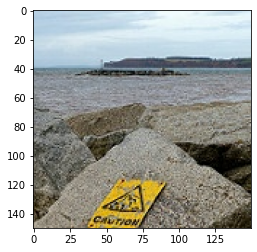

In [32]:
sample = list(val_ds.take(1))[0]
rand_idx = np.random.choice(BATCH_SIZE)
sample_image, sample_label = sample[0].numpy()[rand_idx], sample[1].numpy()[rand_idx]

plt.imshow(sample_image, vmin=0, vmax=1);

print(f"The sample label is {sample_label} which maps to class name: {class_names[sample_label]}") 

One thing to keep in mind is that the model was trained on batches and therefore expects four dimensions: (batch size, x, y, channels) where "batch size" could be 1. Therefore before scoring we need to reshape the sample image to become a "batch of length 1" rather than an individual image.

In [33]:
sample_payload = {
    "input_data": [{"values": sample_image.reshape(1, *sample_image.shape)}]
}
    
pred_probas = client.deployments.score(deployment_id, sample_payload)['predictions'][0]['values']
print(pred_probas)

[[2.9850245937268483e-06, 8.272384548035916e-06, 0.02621774561703205, 0.003962320275604725, 0.9693398475646973, 0.0004688375338446349]]


Now that we have the predicted probabilities we simply take the argmax to convert the prediction into a class (note, we could have added this logic on the deployment side):

In [34]:
pred_class = np.argmax(pred_probas)
print(f"The predicted class is {pred_class} which maps to class name: {class_names[pred_class]}") 

The predicted class is 4 which maps to class name: sea


Yay! Our model predicted the right label.

## 3.6 Clean up the environment

Since this is a demo deployment, we clean up all resources used:

In [35]:
client.deployments.delete(deployment_id)

'SUCCESS'

In [36]:
client.repository.delete(model_id)

'SUCCESS'